<a href="https://colab.research.google.com/github/vischia/adfm_2024-2025/blob/master/04a_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Datos en Física Moderna 2024-2025
@Pietro Vischia (pietro.vischia@cern.ch)


## Pietro Vischia (Universidad de Oviedo and ICTEA), pietro.vischia@cern.ch

### A few global settings

- If you run on colab, set to `True` the relevant environmental variable.

This tutorial will assume you have a few GB free wherever you are running (locally on your machine, or in your google drive account)


In [1]:
runOnColab = False

In [2]:
if runOnColab:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/adfm_2024-2025/"

    !pip install livelossplot shap uproot

In [3]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import re
import math
import socket
import json
import pickle
import gzip
import copy
import array
import numpy as np
import numpy.lib.recfunctions as recfunc
from tqdm import tqdm

from scipy.optimize import newton
from scipy.stats import norm

import uproot

import datetime
from timeit import default_timer as timer

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
try:
    # See #1137: this allows compatibility for scikit-learn >= 0.24
    from sklearn.utils import safe_indexing
except ImportError:
    from sklearn.utils import _safe_indexing

import pandas as pd


You have programmed a neural network from scratch. Now you will use the library `torch`.

In [4]:
#!pip install torch torchinfo
import torchinfo
import torch
torch.manual_seed(0)

import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn.functional as F

In [5]:
# This line ownloads the data only if you haven't done so yet

if not os.path.isfile("data/signal_blind20.root"): 
    !mkdir data; cd data/; wget https://www.hep.uniovi.es/vischia/lisbon_ml_school/lisbon_ml_school_tth.tar.gz; tar xzvf lisbon_ml_school_tth.tar.gz; rm lisbon_ml_school_tth.tar.gz; cd -;
else:
    print("Data were already downloaded, I am not downloading them again.")

Data were already downloaded, I am not downloading them again.


The data set is made of three files, one per background (`background_1` is ttW, `background_2`is Drell-Yan.
The ttH signal events file corresponds to only a percentage of the full data set: the rest is used in the data challenge (for schools where I offer a data challenge).

In [6]:
import uproot

sig = uproot.open('data/signal_blind20.root')['Friends'].arrays(library="pd")
bk1 = uproot.open('data/background_1.root')['Friends'].arrays(library="pd")
bk2 = uproot.open('data/background_2.root')['Friends'].arrays(library="pd")


## Data inspection

See the notebook `02_data_inspection.ipynb`

In [7]:
# Create a new column 'label' and set its value to 1 or 0 for all rows (=events)
sig['label'] = 1 
bk1['label'] = 0
bk2['label'] = 0

# Merge the two backgrounds into one dataframe
bkg = pd.concat([bk1, bk2])

print(f"bkg1 shape {bk1.shape}")
print(f"bkg2 shape {bk2.shape}")
print(f"bkg1+bkg2 shape {bkg.shape}")

# Merge the signal and background into one dataframe
print(f" Signal shape {sig.shape}")
print(f" Bkg shape {bkg.shape}")

data = pd.concat([sig,bkg])

print(f" Data shape {data.shape}")
print(data.columns)

# Filter data
data=data[data['Hreco_Lep2_pt']==-99]
# Drop unneeded features
data = data.drop(["index","Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", 
                  "Hreco_evt_tag","Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y", "Hreco_More5_Jets_pt", "Hreco_More5_Jets_eta", "Hreco_More5_Jets_phi", "Hreco_More5_Jets_mass",], axis=1 )


print(f" Data shape {data.shape}")
print(data.columns)
print(f"In this dataframe we finally have {data[data['label']==1].shape[0]} signal and {data[data['label']==0].shape[0]} background events")
print("Sanity check: look for NAN numbers in any of the rows or columns")
print(data.isna().any())


data = data.sample(frac=1).reset_index(drop=True)
data.head(10)


print("There are NaN-filled elements:", data.isna().any().any())

X = data.drop(["label"], axis=1)
y = data["label"]

print(f"data shape {data.shape}")
print(f"input feature shape {X.shape}")
print(f"label (=target) shape {y.shape}")


bkg1 shape (556648, 35)
bkg2 shape (1034904, 35)
bkg1+bkg2 shape (1591552, 35)
 Signal shape (299287, 36)
 Bkg shape (1591552, 35)
 Data shape (1890839, 36)
Index(['index', 'Hreco_Lep0_pt', 'Hreco_Lep1_pt', 'Hreco_Lep2_pt',
       'Hreco_HadTop_pt', 'Hreco_All5_Jets_pt', 'Hreco_More5_Jets_pt',
       'Hreco_Jets_plus_Lep_pt', 'Hreco_Lep0_eta', 'Hreco_Lep1_eta',
       'Hreco_Lep2_eta', 'Hreco_HadTop_eta', 'Hreco_All5_Jets_eta',
       'Hreco_More5_Jets_eta', 'Hreco_Jets_plus_Lep_eta', 'Hreco_Lep0_phi',
       'Hreco_Lep1_phi', 'Hreco_Lep2_phi', 'Hreco_HadTop_phi',
       'Hreco_All5_Jets_phi', 'Hreco_More5_Jets_phi',
       'Hreco_Jets_plus_Lep_phi', 'Hreco_Lep0_mass', 'Hreco_Lep1_mass',
       'Hreco_Lep2_mass', 'Hreco_HadTop_mass', 'Hreco_All5_Jets_mass',
       'Hreco_More5_Jets_mass', 'Hreco_Jets_plus_Lep_mass', 'Hreco_TopScore',
       'Hreco_met', 'Hreco_met_phi', 'Hreco_HTXS_Higgs_pt',
       'Hreco_HTXS_Higgs_y', 'Hreco_evt_tag', 'label'],
      dtype='object')
 Data shape (110

In [8]:
signal = sig.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag", "Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )
bkg1 = bk1.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag","Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )
bkg2 = bk2.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag","Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )

X_train_orig, X_test_orig, y_train_orig, y_test_orig = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

print(f"We have {len(X_train_orig)} training samples with {sum(y_train_orig)} signal and {sum(1-y_train_orig)} background events")
print(f"We have {len(X_test_orig)} testing samples with {sum(y_test_orig)} signal and {sum(1-y_test_orig)} background events")


We have 739525 training samples with 138086 signal and 601439 background events
We have 364245 testing samples with 67981 signal and 296264 background events


In [9]:
X_train_conv = X_train_orig.copy()
y_train_conv = y_train_orig.copy()
X_test_conv = X_test_orig.copy()
y_test_conv = y_test_orig.copy()

X_train = X_train_orig.copy()
y_train = y_train_orig.copy()
X_test = X_test_orig.copy()
y_test = y_test_orig.copy()


from sklearn.preprocessing import (
    MaxAbsScaler, # maxAbs
    MinMaxScaler, # MinMax
    Normalizer, # Normalization (equal integral)
    StandardScaler# standard scaling
)
from sklearn.decomposition import PCA

# Scale the input features and the target variable
for column in X_train.columns:
    scaler = StandardScaler().fit(X_train.filter([column], axis=1))
    X_train[column] = scaler.transform(X_train.filter([column], axis=1))
    X_test[column] = scaler.transform(X_test.filter([column], axis=1))


For neural networks we will use `pytorch`, a backend designed natively for tensor operations.
I prefer it to tensorflow, because it exposes (i.e. you have to call them explicitly in your code) the optimizer steps and the backpropagation steps.

You could also use the `tensorflow` backend, either directly or through the `keras` frontend.
Saying "I use keras" does not tell you which backend is being used. It used to be either `tensorflow` or `theano`. Nowadays `keras` is I think almost embedded inside tensorflow, but it is still good to specify.

`torch` handles the data management via the `Dataset` and `DataLoader` classes.
Here we don't need any specific `Dataset` class, because we are not doing sophisticated things, but you may need that in the future.

The `Dataloader` class takes care of providing quick access to the data by sampling batches that are then fed to the network for (mini)batch gradient descent.

In [10]:
class MyDataset(Dataset):
    def __init__(self, X, y, device=torch.device("cpu")):
        self.X = torch.Tensor(X.values if isinstance(X, pd.core.frame.DataFrame) else X).to(device)
        self.y = torch.Tensor(y.values).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        label = self.y[idx]
        datum = self.X[idx]
        
        return datum, label

batch_size=512 # Minibatch learning


train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print(train_features)

Feature batch shape: torch.Size([512, 23])
Labels batch shape: torch.Size([512])
tensor([[-0.6524, -0.8481, -0.8887,  ..., -1.0518, -1.1570,  0.1536],
        [ 0.4353, -0.8758,  0.2850,  ...,  0.9428,  0.5316, -0.9848],
        [-0.8084, -0.2882,  1.0333,  ...,  0.9547,  0.8158,  1.2985],
        ...,
        [ 1.2503,  1.2274,  0.9124,  ...,  0.9469, -0.5680,  0.1751],
        [ 0.7081,  0.9147, -0.8887,  ..., -1.0518,  0.3946, -1.2922],
        [-0.0983,  0.8393, -0.8887,  ..., -1.0518, -0.8826, -1.3359]])


For educational purposes, let's get access the data loader via its iterator, and sample a single batch by calling `next` on the iterator

In [11]:
random_batch_X, random_batch_y = next(iter(train_dataloader))
print(random_batch_X.shape, random_batch_y.shape) 
print(random_batch_X)

torch.Size([512, 23]) torch.Size([512])
tensor([[-0.0829,  0.5552,  2.8226,  ...,  0.9556,  1.4258,  0.4968],
        [-0.0944,  1.1259,  0.8761,  ...,  0.9556, -0.7165, -1.5668],
        [ 0.1636,  0.6540,  0.4924,  ...,  0.9548, -0.2291, -0.7058],
        ...,
        [ 2.4244, -0.3471,  0.5016,  ...,  0.9557, -0.0697, -1.4956],
        [-0.8990, -0.8960, -0.8887,  ..., -1.0518,  0.9350,  1.1619],
        [-0.7141, -0.8403, -0.8887,  ..., -1.0518, -0.5911,  0.2002]])


Let's build a simple neural network, by inheriting from the `nn.Module` class. **This is very crucial, because that class is the responsible for providing the automatic differentiation infrastructure for tracking parameters and doing backpropagation**

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, ninputs, device=torch.device("cpu")):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(ninputs, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(), 
            nn.Linear(64,8),
            nn.Sigmoid(),
            nn.Linear(8, 1)
        )
        self.device=device
        self.linear_relu_stack.to(self.device)

    def forward(self, x):
        # Pass data through conv1
        y = self.linear_relu_stack(x)
        return y

Let's instantiate the neural network and print some info on it

In [13]:
model = NeuralNetwork(X_train.shape[1])

print(model) # some basic info

print("Now let's see some more detailed info by using the torchinfo package")
torchinfo.summary(model, input_size=(batch_size, X_train.shape[1])) # the input size is (batch size, number of features)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=23, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=8, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)
Now let's see some more detailed info by using the torchinfo package


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [512, 1]                  --
├─Sequential: 1-1                        [512, 1]                  --
│    └─Linear: 2-1                       [512, 512]                12,288
│    └─ReLU: 2-2                         [512, 512]                --
│    └─Linear: 2-3                       [512, 128]                65,664
│    └─ReLU: 2-4                         [512, 128]                --
│    └─Linear: 2-5                       [512, 64]                 8,256
│    └─ReLU: 2-6                         [512, 64]                 --
│    └─Linear: 2-7                       [512, 8]                  520
│    └─Sigmoid: 2-8                      [512, 8]                  --
│    └─Linear: 2-9                       [512, 1]                  9
Total params: 86,737
Trainable params: 86,737
Non-trainable params: 0
Total mult-adds (M): 44.41
Input size (MB): 0.05
Forward/backward pass siz

Now let's introduce a crucial concept: `torch` lets you manage in which device you want to put your data and models, to optimize access at different stages

In [14]:
devicestring = "mps" # "mps" for macos. "cuda" for NVIDIA gpus accessing them with the CUDA language interface, "cpu" for CPUs

device = torch.device("cuda:0" if torch.cuda.is_available() else devicestring)


# Get a batch from the dataloader
random_batch_X, random_batch_y = next(iter(train_dataloader))

print("The original dataloader resides in", random_batch_X.get_device())

# Let's reinstantiate the dataset
device = torch.device("mps") #MPS is for Apple
train_dataset = MyDataset(X_train, y_train, device=device)
test_dataset = MyDataset(X_test, y_test, device=device)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

random_batch_X, random_batch_y = next(iter(train_dataloader))

print("The new dataloader puts the batches in in", random_batch_X.get_device())

# Reinstantiate the model, on the chosen device
model = NeuralNetwork(X_train.shape[1], device)


The original dataloader resides in -1
The new dataloader puts the batches in in 0


We have learned how load the data into the GPU, how to define and instantiate a model. Now we need to define a training loop.

In `keras`, this is wrapped hidden into the `.fit()` method, which I think is bad because it hides the actual procedure.

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, device):
    size = len(dataloader.dataset)
    losses=[] # Track the loss function
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    #for batch, (X, y) in enumerate(dataloader):
    for (X,y) in tqdm(dataloader):
        # Reset gradients (to avoid their accumulation)
        optimizer.zero_grad()
        # Compute prediction and loss
        yhat = model(X)
        #if (all_equal3(pred.detach().numpy())):
        #    print("All equal!")
        loss = loss_fn(yhat.squeeze(dim=1), y)
        losses.append(loss.detach().cpu())
        # Backpropagation
        loss.backward()
        optimizer.step()

    scheduler.step()
    return np.mean(losses)

Now we need to define the loop that is run on the test dataset.

**The test dataset is just used for evaluating the output of the model. No backpropagation is needed, therefore backpropagation must be switched off!!!**

In [16]:
def test_loop(dataloader, model, loss_fn, device):
    losses=[] # Track the loss function
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        #for X, y in dataloader:
        for (X,y) in tqdm(dataloader):
            yhat = model(X)
            loss = loss_fn(yhat.squeeze(dim=1), y).item()
            losses.append(loss)
            test_loss += loss
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    return np.mean(losses)

We are now read to train this!
At the moment we are trying to do classification. We will set our loss function to be the cross entropy.

Torch provides the functionality to use generic functions as loss function. We will show an example one.

In [18]:

#loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.CrossEntropyLoss()

#loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
def my_simple_loss(y_hat,y):
    loss = torch.mean( y[:,0]*torch.pow( y_hat - y[:,1], 2))
    #quad=-1,2
    #lin=-2,1
    #sm=-3,0
    return loss
# We would use this loss function in the same way as the other predefined loss functions:
# loss_fn=my_simple_loss


Time to define optimizer and scheduler, number of epochs, and finally to train!

Epoch 1
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 93.71it/s]


Avg train loss 547.65936 , Avg test loss 544.2728819257758 Current learning rate [0.009000000000000001]
Epoch 2
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 96.56it/s]


Avg train loss 543.8984 , Avg test loss 543.2573495714852 Current learning rate [0.008100000000000001]
Epoch 3
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:06<00:00, 102.98it/s]


Avg train loss 542.9049 , Avg test loss 543.5323889443044 Current learning rate [0.007290000000000001]
Epoch 4
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 97.75it/s]


Avg train loss 542.2718 , Avg test loss 542.8523708300644 Current learning rate [0.006561000000000002]
Epoch 5
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 99.65it/s]


Avg train loss 541.8174 , Avg test loss 542.2400930383233 Current learning rate [0.005904900000000002]
Epoch 6
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 100.07it/s]


Avg train loss 541.3949 , Avg test loss 541.6921231344844 Current learning rate [0.005314410000000002]
Epoch 7
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 92.97it/s]


Avg train loss 540.9958 , Avg test loss 541.5852770001701 Current learning rate [0.004782969000000002]
Epoch 8
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 96.10it/s]


Avg train loss 540.55804 , Avg test loss 541.6462932329499 Current learning rate [0.004304672100000002]
Epoch 9
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 91.39it/s]


Avg train loss 540.1366 , Avg test loss 541.249904889739 Current learning rate [0.003874204890000002]
Epoch 10
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 93.29it/s]


Avg train loss 539.6403 , Avg test loss 541.0569982207223 Current learning rate [0.003486784401000002]
Epoch 11
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 95.74it/s]


Avg train loss 539.1911 , Avg test loss 540.9556591591139 Current learning rate [0.003138105960900002]
Epoch 12
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 95.92it/s]


Avg train loss 538.8087 , Avg test loss 540.6127772599124 Current learning rate [0.0028242953648100018]
Epoch 13
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 93.35it/s]


Avg train loss 538.4247 , Avg test loss 540.6653554680643 Current learning rate [0.0025418658283290017]
Epoch 14
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 93.91it/s]


Avg train loss 538.07776 , Avg test loss 540.8285679335005 Current learning rate [0.0022876792454961017]
Epoch 15
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 99.35it/s]


Avg train loss 537.734 , Avg test loss 540.8987949457062 Current learning rate [0.0020589113209464917]
Epoch 16
-------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 101.11it/s]


Avg train loss 537.3794 , Avg test loss 541.0298869100849 Current learning rate [0.0018530201888518425]
Epoch 17
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 97.16it/s]


Avg train loss 537.02264 , Avg test loss 541.71417112029 Current learning rate [0.0016677181699666583]
Epoch 18
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 90.41it/s]


Avg train loss 536.76447 , Avg test loss 541.2724801395716 Current learning rate [0.0015009463529699924]
Epoch 19
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 97.49it/s]


Avg train loss 536.43475 , Avg test loss 540.8634624909819 Current learning rate [0.0013508517176729932]
Epoch 20
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:07<00:00, 96.19it/s]

Avg train loss 536.1372 , Avg test loss 541.005803997597 Current learning rate [0.001215766545905694]
Done!


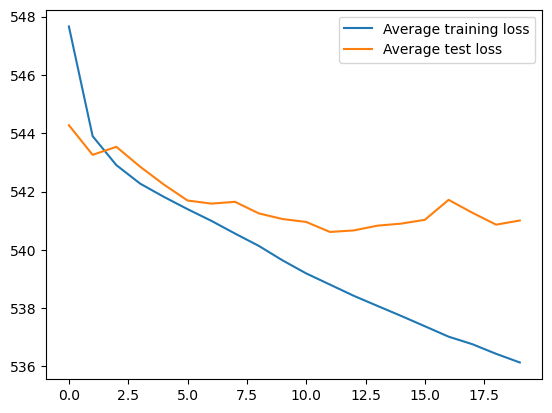

In [19]:
epochs=20
learningRate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train_losses=[]
test_losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss=train_loop(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    test_loss=test_loop(test_dataloader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print("Avg train loss", train_loss, ", Avg test loss", test_loss, "Current learning rate", scheduler.get_last_lr())
print("Done!")


plt.plot(train_losses, label="Average training loss")
plt.plot(test_losses, label="Average test loss")
plt.legend(loc="best")

Output of the classifier

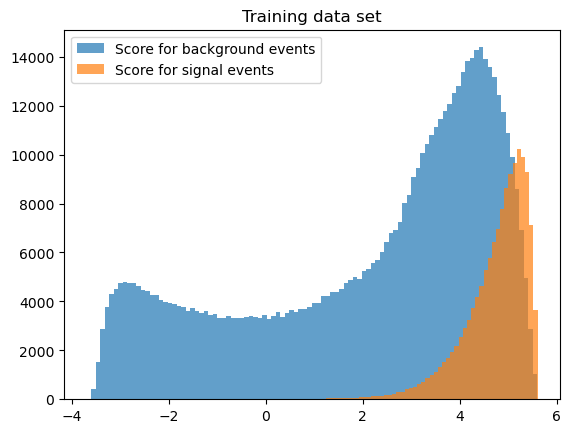

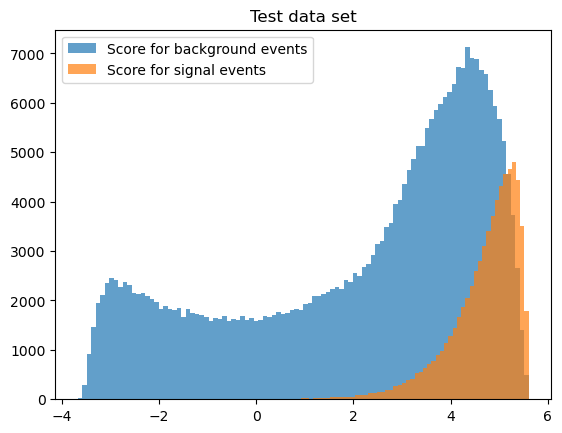

In [27]:
nbins=100
plt.figure()
plt.hist(model(torch.tensor(X_train.to_numpy(),device=model.device)).numpy(force=True)[y_train==0], bins=nbins, alpha=0.7, label = "Score for background events")
plt.hist(model(torch.tensor(X_train.to_numpy(),device=model.device)).numpy(force=True)[y_train==1], bins=nbins, alpha=0.7, label = "Score for signal events")
plt.title("Training data set")
plt.legend(loc="best")
#plt.yscale("log")

plt.figure()
plt.hist(model(torch.tensor(X_test.to_numpy(),device=model.device)).numpy(force=True)[y_test==0], bins=nbins, alpha=0.7, label = "Score for background events")
plt.hist(model(torch.tensor(X_test.to_numpy(),device=model.device)).numpy(force=True)[y_test==1], bins=nbins, alpha=0.7, label = "Score for signal events")
plt.title("Test data set")
plt.legend(loc="best")
#plt.yscale("log")



In [ ]:
def plot_rocs(scores_labels_names):
    plt.figure()
    for score, label, name  in scores_labels_names:
        fpr, tpr, thresholds = roc_curve(label, score)
        plt.plot(
            fpr, tpr, 
            linewidth=2, 
            label=f"{name} (AUC = {100.*auc(fpr, tpr): .2f} %)"
        )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.grid()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic curve")
    plt.legend(loc="lower right")
    plt.show()
    plt.close()

plot_rocs([
    (model(torch.tensor(X_train.to_numpy(),device=model.device)).numpy(force=True), y_train, "Train"), 
    (model(torch.tensor(X_test.to_numpy(),device=model.device)).numpy(force=True), y_test, "Test")  
])

## WHOOPS! The network is not learning anything!!!

What can we do?

Go back to that cell that had this text: `# LABEL OF THIS PLACE HERE, WILL BE USEFUL LATER`
and add there the following lines:


In [24]:
from sklearn.preprocessing import StandardScaler

# NOTE: in earlier versions of the StandardScaler, `.values.reshape(-1,1)` was not needed. The interface must have changed.

for column in X_train.columns:
    scaler = StandardScaler().fit(X_train[column].values.reshape(-1,1))
    X_train[column] = scaler.transform(X_train[column].values.reshape(-1,1))
    X_test[column] = scaler.transform(X_test[column].values.reshape(-1,1))

You could also use the basic syntax recommended by the documentation, as follows, but then you would be standardizing all the features to exacly the same mean. This may work for some data sets, but for this specific one it does not (it actually significantly worsens the performance---you can try ;) ).

```
scaler = StandardScaler().fit(X_train)

X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
```

Rerun starting from that cell, and now check the new loss function evolution.

#### Can you explain what is the effect of these lines and their effect on the gradient descent?

## WHOOPS! The network is not learning anything!!!

What can we do?

This new behaviour is likely caused by a too large value of initial learning rate, that makes training and test sink into two different minima. You can fix it by, for instance, reducing by a factor 10 the initial learning rate above.

## Multiclass

Go back to the original dataset, but now assign different labels to the two backgrounds

In [ ]:
signal = sig.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag", "Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )
bkg1 = bk1.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag","Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )
bkg2 = bk2.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag","Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )

signal['label'] = 2
bkg1['label'] = 1
bkg2['label'] = 0
bkg = pd.concat([bkg1, bkg2])

data = pd.concat([signal,bkg]).sample(frac=1).reset_index(drop=True)
X = data.drop(["label"], axis=1)
y = data["label"]


Now you need to apply the technique of **one-hot encoding** to convert a categorical label into a vector (one dimension per category/class).

Now you need to apply the technique of **one-hot encoding** to convert a categorical label (=0,1,2) into a vector (one dimension per category/class):


| Sample | Categorical | One-hot encoding |
| --- | --- | --- |
| Background 2 | $0$ | $(1,0,0)$ |
| Background 1 | $1$ | $(0,1,0)$ |
| Signal | $2$ | $(0,0,1)$ |


You can use the function `one_hot = torch.nn.functional.one_hot(target)` to one-hot encode the target labels (both for signal and background)

One-hot encoding is described in slide `81`of this morning's lecture.

You can use the function `one_hot = torch.nn.functional.one_hot(target)` to one-hot encode the target labels (both for signal and background)

In [ ]:
# Add this where appropriate
for label in [0,1,2]:
    one_hot = torch.nn.functional.one_hot(torch.tensor(label), num_classes=3)
    print (f"Encoding label '{label}' as '{one_hot.numpy(force=True)}'")

Next you need to recreate the test/train split, using the same lines of code you used for the simple classification problem


Next you have to modify the neural network model: the output must be a dimension-three vector rather than a scalar.

You can use `self.output = nn.Linear(8, 3)` as last layer, and you can prepend it a `SoftMax` or `sigmoid` activation function, to ensure the outputs are interpretable as probabilities



After training, you will need to figure out how to get categorical predictions to be able to test performance (for instance to produce the ROC curve for each pair of classes, or for one class against all the others.

However, the minimal useful thing is to produce the confusion matrix we have seen in this morning's lecture:

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pred_y = model(torch.tensor(X_test.values, device=device)).numpy(force=True)
pred_class = np.argmax(pred_y,axis=1)
true_class = np.argmax(y_test.numpy(force=True),axis=1)

print (f"{'true class':10s} | {'predicted class':15s} ")
print ('='*30)
for i in range(10):
    print (f"{true_class[i]:<10d} | {pred_class[i]:<15d}")

confusion_mat = confusion_matrix(true_class, pred_class, normalize='true')
                                 
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['bkg2', 'bkg1', 'sig'])
disp.plot()
plt.show()
plt.close()

## Exercise

Calculate the predictions for each class, then plot the ROC curve for:

- signal vs bkg1
- signal vs bkg2
- bkg vs bkg2

Then, in another plot, plot:

- signal vs all backgrounds


# Regression

Go back to the original dataset, but now we will use the Higgs boson transverse momentum as a target for regression.
Notice how we avoid dropping the `Hreco_HTXS_Higgs_pt` column from the dataset, and we put that one into the target `y`.

The training will be done only on the signal (you want to regress the momentum in the specific process of interest).

We will still use the backgrounds, but just to make comparisons, in the sense that once you have the pT regressor, you can apply it to ttH (signal) events, but also separately to background events to see what's the shape of the regressed pT where the regressed pT is not supposed to exist (Drell-Yan events) or when it is supposed to exist but for another particle (W boson in ttW) events.

In [ ]:
signal = sig.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag", "Hreco_HTXS_Higgs_y"], axis=1 )
bkg1 = bk1.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag", "Hreco_HTXS_Higgs_y"], axis=1 )
bkg2 = bk2.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag", "Hreco_HTXS_Higgs_y"], axis=1 )

X = signal.drop(["Hreco_HTXS_Higgs_pt"], axis=1)
y = signal["Hreco_HTXS_Higgs_pt"]

`# MIMIMI HERE SOMETHING THERE WILL BE`

Now, since the target is a regression, we need to tweak two things.

First, the last activation function should not be a `nn.Sigmoid()` anymore (which forces the output to be in the range `[0,1]`. You should now use `nn.ReLU()`.

Second, the cross entropy loss is not appropriate anymore. You should use the `MSELoss()`.

With these two changes, you should be able to regress the Higgs boson transverse momentum.

Plot the loss function, and then produce a scatter plot of the neural network prediction versus the true value of the Higgs transverse momentum (`y` vs `pred=model(x)`). Finally, produce a plot where you show the shape of the pT regressor separately for the signal, for bkg1 (ttW),  and for bkg2 (Drell-Yan). For this latest plot, you should normalize to 1 the three distributions, to check for shape differences (you can use `density=True` when plotting).

## What is going on!?!??! Why is the loss always NotANumber?

This is because the network is not managing to cope with the vast range of values for the output (the pT).

Try reducing the range of values by adding, in correspondence of `# MIMIMI HERE SOMETHING THERE WILL BE`, the following transformation:


`y = signal["Hreco_HTXS_Higgs_pt"].apply(np.log)`

## Somehow better, but still suboptimal!

The spread of the predictions is too large to be used. Nonconvex optimization is difficult, and sometimes tweaking the model and training to success is tricky.

A way of hacking this problem is to use a more sophisticated loss function that penalizes predictions with different means. You can try!

```
class penalized_mse(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        #return ((pred-target)**2).mean() + 2*((torch.log(pred)-torch.log(target))**2).mean()
        print(pred.mean(), pred.var(),target.var())
        return ((pred-target)**2).mean()*(torch.abs(pred.var()-target.var()))

loss_fn=penalized_mse()
```

Also see if modifying the network can help to improve the prediction. For example ...
* add dropout layers
* use a different activation function
* add batch normalization layers
* reduce the number of layer
* reduce the number of nodes

### The end